In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import cv2
import numpy as np
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ['NORMAL', 'BACTERIA', 'VIRUS']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []
        
        # Load data paths and labels
        for class_name in self.classes:
            class_path = os.path.join(data_dir, class_name)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def adaptive_masking_equalized(self, image):
        # Convert PIL to numpy array
        image_np = np.array(image.convert('L'))
        
        # Adaptive masking
        min_intensity = np.min(image_np)
        max_intensity = np.max(image_np)
        threshold_value = min_intensity + 0.9 * (max_intensity - min_intensity)
        _, binary_mask = cv2.threshold(image_np, threshold_value, 255, cv2.THRESH_BINARY)
        
        # Apply morphological operations
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        
        # Apply mask to original image
        masked_image = cv2.bitwise_and(image_np, image_np, mask=cv2.bitwise_not(mask))
        
        # Histogram equalization
        equalized_image = cv2.equalizeHist(masked_image)
        
        return Image.fromarray(equalized_image)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply adaptive masking and histogram equalization
        processed_image = self.adaptive_masking_equalized(image)
        
        # Convert back to RGB for DenseNet input
        processed_image = Image.merge('RGB', (processed_image, processed_image, processed_image))
        
        if self.transform:
            processed_image = self.transform(processed_image)
            
        return processed_image, label

    def __len__(self):
        return len(self.images)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_acc = 0.0
    training_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total
        training_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total
        validation_losses.append(epoch_val_loss)
        
        print(f'Train Loss: {epoch_train_loss:.4f} Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f} Val Acc: {epoch_val_acc:.2f}%')
        
        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        scheduler.step()
    
    return training_losses, validation_losses

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return classification_report(all_labels, all_preds, target_names=['Normal', 'Bacteria', 'Virus']), \
           confusion_matrix(all_labels, all_preds)

def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Data transforms
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = ChestXrayDataset('/kaggle/input/chest-xray/chest_xray_jj/train/', transform=data_transforms)
    val_dataset = ChestXrayDataset('/kaggle/input/chest-xray/chest_xray_jj/val/', transform=data_transforms)
    test_dataset = ChestXrayDataset('/kaggle/input/chest-xray/chest_xray_jj/test', transform=data_transforms)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    # Initialize model
    model = models.densenet161(pretrained=True)
    
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify the classifier
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 3)  # 3 classes
    model = model.to(device)
    
    # Training parameters
    criterion = nn.CrossEntropyLoss()
    
    # First phase: Feature extraction (20 epochs)
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    print("Phase 1: Feature Extraction Training")
    train_losses_1, val_losses_1 = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, 
        num_epochs=20, device=device
    )
    
    # Second phase: Fine-tuning (unfreeze last few layers)
    print("Phase 2: Fine-tuning")
    # Unfreeze last 2 dense blocks
    for param in model.features.denseblock4.parameters():
        param.requires_grad = True
    for param in model.features.denseblock3.parameters():
        param.requires_grad = True
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    train_losses_2, val_losses_2 = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, 
        num_epochs=20, device=device
    )
    
    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pth'))
    report, conf_matrix = evaluate_model(model, test_loader, device)
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses_1 + train_losses_2, label='Training Loss')
    plt.plot(val_losses_1 + val_losses_2, label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:07<00:00, 16.0MB/s] 


Phase 1: Feature Extraction Training
Epoch 1/20
----------


100%|██████████| 163/163 [01:35<00:00,  1.71it/s]


Train Loss: 0.6514 Train Acc: 73.43%
Val Loss: 0.6491 Val Acc: 86.36%
Epoch 2/20
----------


100%|██████████| 163/163 [01:26<00:00,  1.88it/s]


Train Loss: 0.5387 Train Acc: 77.66%
Val Loss: 0.4969 Val Acc: 81.82%
Epoch 3/20
----------


100%|██████████| 163/163 [01:25<00:00,  1.90it/s]


Train Loss: 0.5033 Train Acc: 79.22%
Val Loss: 0.3255 Val Acc: 95.45%
Epoch 4/20
----------


100%|██████████| 163/163 [01:26<00:00,  1.89it/s]


Train Loss: 0.4904 Train Acc: 79.20%
Val Loss: 0.4559 Val Acc: 77.27%
Epoch 5/20
----------


100%|██████████| 163/163 [01:23<00:00,  1.96it/s]


Train Loss: 0.4744 Train Acc: 80.00%
Val Loss: 0.3788 Val Acc: 86.36%
Epoch 6/20
----------


100%|██████████| 163/163 [01:23<00:00,  1.94it/s]


Train Loss: 0.4571 Train Acc: 80.60%
Val Loss: 0.3233 Val Acc: 95.45%
Epoch 7/20
----------


100%|██████████| 163/163 [01:25<00:00,  1.91it/s]


Train Loss: 0.4554 Train Acc: 80.71%
Val Loss: 0.4018 Val Acc: 90.91%
Epoch 8/20
----------


100%|██████████| 163/163 [01:24<00:00,  1.94it/s]


Train Loss: 0.4210 Train Acc: 82.32%
Val Loss: 0.3230 Val Acc: 95.45%
Epoch 9/20
----------


100%|██████████| 163/163 [01:24<00:00,  1.92it/s]


Train Loss: 0.4205 Train Acc: 82.69%
Val Loss: 0.3219 Val Acc: 95.45%
Epoch 10/20
----------


100%|██████████| 163/163 [01:26<00:00,  1.88it/s]


Train Loss: 0.4135 Train Acc: 82.59%
Val Loss: 0.4144 Val Acc: 90.91%
Epoch 11/20
----------


100%|██████████| 163/163 [01:23<00:00,  1.95it/s]


Train Loss: 0.4220 Train Acc: 82.42%
Val Loss: 0.3536 Val Acc: 95.45%
Epoch 12/20
----------


100%|██████████| 163/163 [01:25<00:00,  1.91it/s]


Train Loss: 0.4118 Train Acc: 83.13%
Val Loss: 0.4351 Val Acc: 90.91%
Epoch 13/20
----------


100%|██████████| 163/163 [01:24<00:00,  1.92it/s]


Train Loss: 0.4138 Train Acc: 83.15%
Val Loss: 0.3220 Val Acc: 95.45%
Epoch 14/20
----------


100%|██████████| 163/163 [01:23<00:00,  1.94it/s]


Train Loss: 0.4143 Train Acc: 83.30%
Val Loss: 0.3661 Val Acc: 95.45%
Epoch 15/20
----------


100%|██████████| 163/163 [01:26<00:00,  1.89it/s]


Train Loss: 0.4122 Train Acc: 83.19%
Val Loss: 0.3571 Val Acc: 95.45%
Epoch 16/20
----------


100%|██████████| 163/163 [01:25<00:00,  1.92it/s]


Train Loss: 0.4114 Train Acc: 83.03%
Val Loss: 0.3575 Val Acc: 95.45%
Epoch 17/20
----------


100%|██████████| 163/163 [01:22<00:00,  1.97it/s]


Train Loss: 0.4094 Train Acc: 83.38%
Val Loss: 0.3420 Val Acc: 95.45%
Epoch 18/20
----------


100%|██████████| 163/163 [01:22<00:00,  1.97it/s]


Train Loss: 0.4049 Train Acc: 83.57%
Val Loss: 0.3515 Val Acc: 95.45%
Epoch 19/20
----------


100%|██████████| 163/163 [01:24<00:00,  1.92it/s]


Train Loss: 0.4127 Train Acc: 83.11%
Val Loss: 0.3226 Val Acc: 95.45%
Epoch 20/20
----------


100%|██████████| 163/163 [01:23<00:00,  1.96it/s]


Train Loss: 0.4137 Train Acc: 83.09%
Val Loss: 0.3232 Val Acc: 95.45%
Phase 2: Fine-tuning
Epoch 1/20
----------


100%|██████████| 163/163 [01:29<00:00,  1.83it/s]


Train Loss: 0.4404 Train Acc: 81.21%
Val Loss: 0.1756 Val Acc: 95.45%
Epoch 2/20
----------


100%|██████████| 163/163 [01:29<00:00,  1.83it/s]


Train Loss: 0.1458 Train Acc: 95.02%
Val Loss: 0.2737 Val Acc: 90.91%
Epoch 3/20
----------


100%|██████████| 163/163 [01:27<00:00,  1.87it/s]


Train Loss: 0.0413 Train Acc: 99.00%
Val Loss: 0.1804 Val Acc: 90.91%
Epoch 4/20
----------


100%|██████████| 163/163 [01:28<00:00,  1.84it/s]


Train Loss: 0.0195 Train Acc: 99.60%
Val Loss: 0.1260 Val Acc: 90.91%
Epoch 5/20
----------


100%|██████████| 163/163 [01:29<00:00,  1.83it/s]


Train Loss: 0.0120 Train Acc: 99.69%
Val Loss: 0.2758 Val Acc: 86.36%
Epoch 6/20
----------


100%|██████████| 163/163 [01:25<00:00,  1.91it/s]


Train Loss: 0.0195 Train Acc: 99.44%
Val Loss: 0.1366 Val Acc: 95.45%
Epoch 7/20
----------


100%|██████████| 163/163 [01:28<00:00,  1.85it/s]


Train Loss: 0.0841 Train Acc: 97.09%
Val Loss: 0.0457 Val Acc: 100.00%
Epoch 8/20
----------


100%|██████████| 163/163 [01:28<00:00,  1.84it/s]


Train Loss: 0.0340 Train Acc: 99.14%
Val Loss: 0.1269 Val Acc: 100.00%
Epoch 9/20
----------


100%|██████████| 163/163 [01:29<00:00,  1.82it/s]


Train Loss: 0.0120 Train Acc: 99.87%
Val Loss: 0.0649 Val Acc: 100.00%
Epoch 10/20
----------


100%|██████████| 163/163 [01:29<00:00,  1.81it/s]


Train Loss: 0.0066 Train Acc: 100.00%
Val Loss: 0.0742 Val Acc: 100.00%
Epoch 11/20
----------


100%|██████████| 163/163 [01:28<00:00,  1.85it/s]


Train Loss: 0.0047 Train Acc: 100.00%
Val Loss: 0.0915 Val Acc: 100.00%
Epoch 12/20
----------


100%|██████████| 163/163 [01:26<00:00,  1.88it/s]


Train Loss: 0.0040 Train Acc: 99.98%
Val Loss: 0.1034 Val Acc: 100.00%
Epoch 13/20
----------


100%|██████████| 163/163 [01:28<00:00,  1.84it/s]


Train Loss: 0.0032 Train Acc: 100.00%
Val Loss: 0.0717 Val Acc: 100.00%
Epoch 14/20
----------


100%|██████████| 163/163 [01:26<00:00,  1.89it/s]


Train Loss: 0.0035 Train Acc: 100.00%
Val Loss: 0.0781 Val Acc: 100.00%
Epoch 15/20
----------


100%|██████████| 163/163 [01:29<00:00,  1.82it/s]


Train Loss: 0.0035 Train Acc: 99.98%
Val Loss: 0.0669 Val Acc: 100.00%
Epoch 16/20
----------


100%|██████████| 163/163 [01:26<00:00,  1.88it/s]


Train Loss: 0.0022 Train Acc: 100.00%
Val Loss: 0.0716 Val Acc: 100.00%
Epoch 17/20
----------


100%|██████████| 163/163 [01:27<00:00,  1.86it/s]


Train Loss: 0.0021 Train Acc: 100.00%
Val Loss: 0.0765 Val Acc: 100.00%
Epoch 18/20
----------


100%|██████████| 163/163 [01:28<00:00,  1.83it/s]


Train Loss: 0.0024 Train Acc: 100.00%
Val Loss: 0.0833 Val Acc: 100.00%
Epoch 19/20
----------


100%|██████████| 163/163 [01:30<00:00,  1.79it/s]


Train Loss: 0.0019 Train Acc: 100.00%
Val Loss: 0.0595 Val Acc: 100.00%
Epoch 20/20
----------


100%|██████████| 163/163 [01:28<00:00,  1.85it/s]


Train Loss: 0.0020 Train Acc: 100.00%
Val Loss: 0.0902 Val Acc: 100.00%


<ipython-input-3-884fa43ce6cc>:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
100%|██████████| 20/20 [00:12<00:00,  1


Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.52      0.68       234
    Bacteria       0.78      0.86      0.82       242
       Virus       0.51      0.80      0.62       148

    accuracy                           0.72       624
   macro avg       0.76      0.73      0.71       624
weighted avg       0.79      0.72      0.72       624


Confusion Matrix:
[[122  29  83]
 [  2 209  31]
 [  0  29 119]]


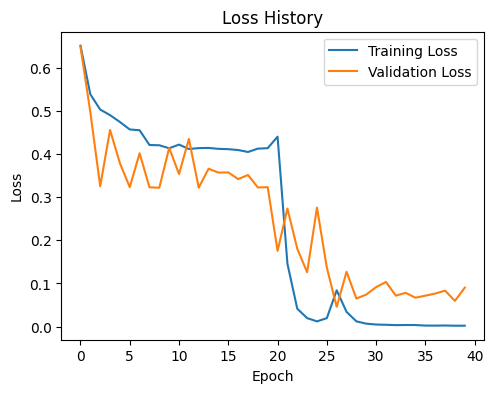

In [4]:
if __name__ == "__main__":
    main()